# Gaussian Mixture Model Distribution Fits
## Derive Cutoffs for Actionable Subtype Vectors in The Cancer Genome Atlas 

Using methodology derived from <cite data-cite="5029384/X9LAFLYN"></cite> for biomarker cutoff identification.

Terminology:
- Tissue: The specific tissue (e.g. Lung, Kidney) for a group of samples
- Type/Subtype: The specific subtype (e.g. Lung Adenocarcinoma, Lung Squamous Cell) for a group of samples
- Tumor: TCGA Tumor samples within the context of a Tissue or Type
- Normal: TCGA Normal samples within the context of a Tissue or Type
- GTEx: GTEx samples within the context of a Tissue or Type

### Inputs and Functions

In [1]:
import pandas as pd
import numpy as np
import rnaseq_lib as r
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import holoviews as hv
hv.extension('bokeh', logo=False)

In [5]:
# Synapse ID: syn12009613
data_path = '/mnt/data/Objects/tcga_gtex_data.hd5'
exp = pd.read_hdf(data_path, key='exp')
met = pd.read_hdf(data_path, key='met')
df = r.data.add_metadata_to_exp(exp, met)

In [6]:
h = r.plot.Holoview(df)

In [7]:
# Subset by dataset
tumor = df[df.tumor == 'yes']
normal = df[df.label == 'tcga-normal']
gtex = df[df.label == 'gtex']
print 'Number of Tumor Type: {}'.format(len(tumor.type.unique()))
print 'Number of Normal Type: {}'.format(len(normal.type.unique()))
print 'Nubmer of GTEx Tissue: {}'.format(len(gtex.tissue.unique()))

Number of Tumor Type: 34
Number of Normal Type: 24
Nubmer of GTEx Tissue: 31


In [8]:
def gmm_fit_plot(df, label, gene, groupby='type'):
    g = df[df[groupby] == label]
    t = g[g.tumor == 'yes'][gene].apply(r.math.l2norm)
    return r.math.overlay_gmm_to_hist(t)

In [9]:
def compare_cutoff(group, gene, cutoff, rows, cols,
                   groupby='type', figsize=(12, 16),
                   show_plot=True):
    f, ax = plt.subplots(rows, cols, figsize=figsize, sharex=True)
    ax = ax.flatten()
    records = []
    for i, subtype in enumerate(sorted(group[groupby].unique())):
        dist = group[group[groupby] == subtype][gene].apply(r.math.l2norm)
        
        # Calculate count and percentage of samples
        count = len([x for x in dist if x > cutoff])
        perc = round(float(count) / len(dist) * 100,1)
        records.append((subtype, len(dist), count, perc))
        
        # Plot
        color = 'blue' if perc < 25 else 'red'
        ax[i].hist(dist, density=True, alpha=0.50, 
                   bins=50, label=subtype, color=color)
        ax[i].vlines(cutoff, *ax[i].get_ylim(), 
                     color='red', linestyles='--')        
        
        title = '{} - n={}, p={}'.format(subtype[:20], count, perc)
        ax[i].set_title(title)
    plt.tight_layout()
    # Hide plot if selected
    if not show_plot:
        plt.close()
    
    # Return DF of information in plots
    cols = ['Subtype', 'N', 'n', 'perc']
    df = pd.DataFrame.from_records(records, columns=cols)
    # Filter out tumor samples with n = 0 
    df = df[df.perc > 5]
    return df.sort_values('perc', ascending=False)

## CA9
Tumor hypoxia is associated clinically with therapeutic resistance and poor patient outcomes. One feature of tumor hypoxia is activated expression of carbonic anhydrase IX (CA9), a regulator of pH and tumor growth. Disruption of the downstream bicarbonate products can acidify tumor cells and suppress tumor growth <cite data-cite="5029384/NMV9JUEV"></cite>. Hypoxia also promotes tumour heterogeneity through the epigenetic regulation of CA9 <cite data-cite="5029384/I6MEXV5K"></cite>. CA9 is also a _transmembrane protein_ and is stained for for use as an endogenous marker for investigating hypoxia <cite data-cite="5029384/W8JIRBRJ"></cite>. 

CA9 is part of a family of carbonic anhydrases (zinc metalloenzymes) that catalyze reversible hydration of carbion dioxide to form carbonic acid. _Girentuximab_ (trade name _Rencarex_) is a chimeric IgG1 monoclonal antibody to carbonic anhydrase IX which was granted fast track status and orphan drug designation by the FDA for renal cancer <cite data-cite="5029384/GF2X2K8N"></cite>. In January 2017, Telix Pharmaceuticals Limited, an Australian biotechnology company, announced that it had in-licensed Girentuximab for use as a radioimmunoconjugate, iodine (124I) girentuximab, called _Redectane_ <cite data-cite="5029384/ZRAQ2362"></cite>

RNA-seq gene expression data from The Cancer Genome Atlas (TCGA) and the Genotype Tissue Expression Consortium (GTEx) should corroborate literature claims regarding CA9 expression in Renal Cell Carcinomas (RCCs) . Once validated, the expression motif of RCCS can be compared to other cancer subtypes to suggest candidates for possible repositioning of CA9-targeted drugs.

### Kidney Tumor Fit
Girentuximab, which targets CA9, is for kidney renal cell carcinoma

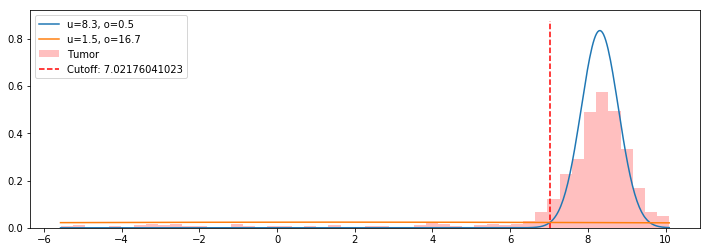

In [26]:
disease = 'Kidney_Renal_Clear_Cell_Carcinoma'
gene = 'CA9'
kidney_cutoff = gmm_fit_plot(df, label=disease, gene=gene)

Using this metric, all tumor samples with a TPM greater than {{kidney_cutoff}} would be marked in the actionable subtype group.

#### Tumor Cutoff Comparison

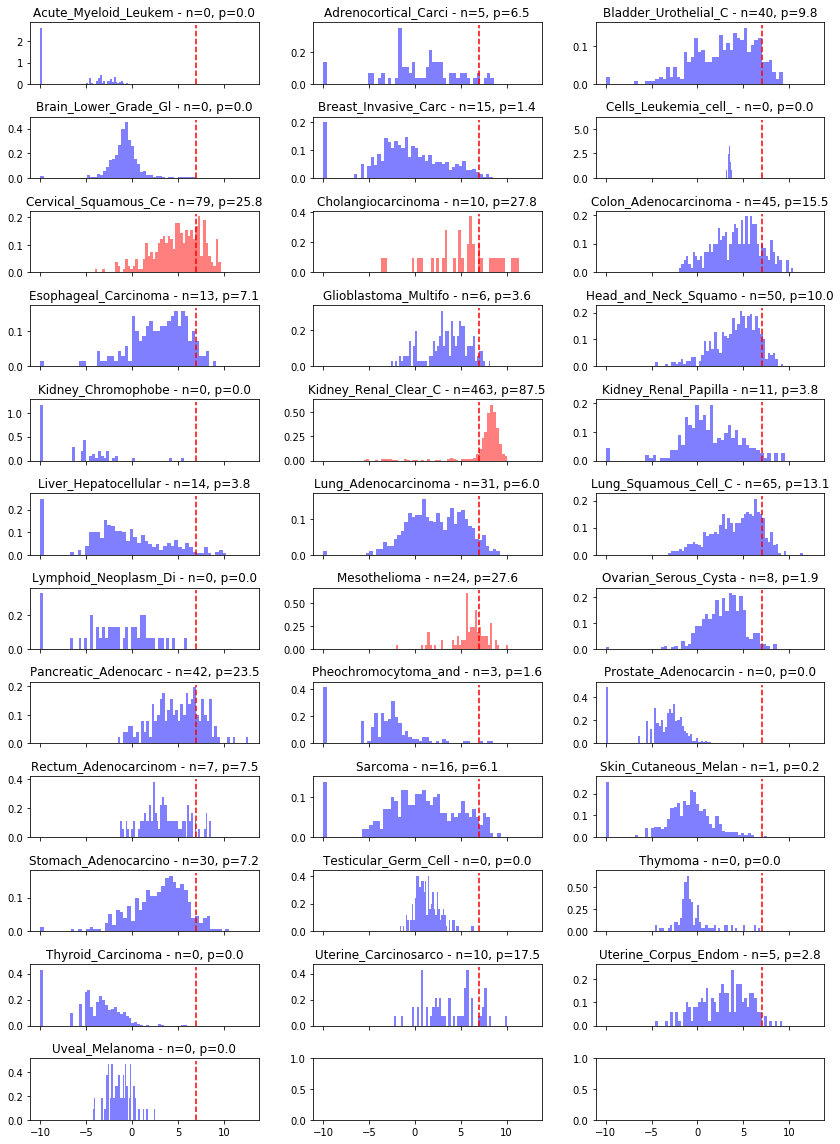

In [27]:
kt = compare_cutoff(tumor, gene=gene, cutoff=kidney_cutoff, rows=12, cols=3)

In [9]:
kt.head(10)

,Subtype,N,n,perc


Literature sources identify overexpression of CA9 in all cancer subtypes that contain a significant number of samples with CA9 expression above the kidney renal cell carcinoma cutoff. 


- Mesothelioma
    - "Carbonic anhydrase IX is expressed in mesothelioma and metastatic clear cell renal cell carcinoma of the lung" <cite data-cite="5029384/L8SQBTJ4"></cite>
- Cholangiocarcinoma
    - "CA9 overexpression is an independent favorable prognostic marker in intrahepatic cholangiocarcinoma" <cite data-cite="5029384/GIUJZ8TR"></cite>
- Cervical Squamous 
    - "The MN/CA9 protein is a tumor-associated antigen that has been shown to have diagnostic utility in identifying cervical dysplasia and carcinoma" <cite data-cite="5029384/42JKD2GI"></cite>
- Pancreatic Adenocarcinoma
    - "VHL inactivation is an important pathway for the development of malignant sporadic pancreatic endocrine tumors" <cite data-cite="5029384/5XGQP6RT"></cite>
- Uterine Carcinosarcoma
    - Tumor carbonic anhydrase 9 expression is associated with the presence of lymph node metastases in uterine cervical cancer <cite data-cite="5029384/62LTJRP8"></cite>

#### Normal Cutoff Comparison
Are any Normal samples included above the cutoff range? If so, the tumor data for that associated subtype should probably be excluded. 

,Subtype,N,n,perc
8,Kidney_Chromophobe,25,10,40.0
10,Kidney_Renal_Papillary_Cell_Carcinoma,32,12,37.5
9,Kidney_Renal_Clear_Cell_Carcinoma,72,23,31.9
5,Esophageal_Carcinoma,13,4,30.8
4,Colon_Adenocarcinoma,41,7,17.1
1,Breast_Invasive_Carcinoma,112,14,12.5
0,Bladder_Urothelial_Carcinoma,19,2,10.5


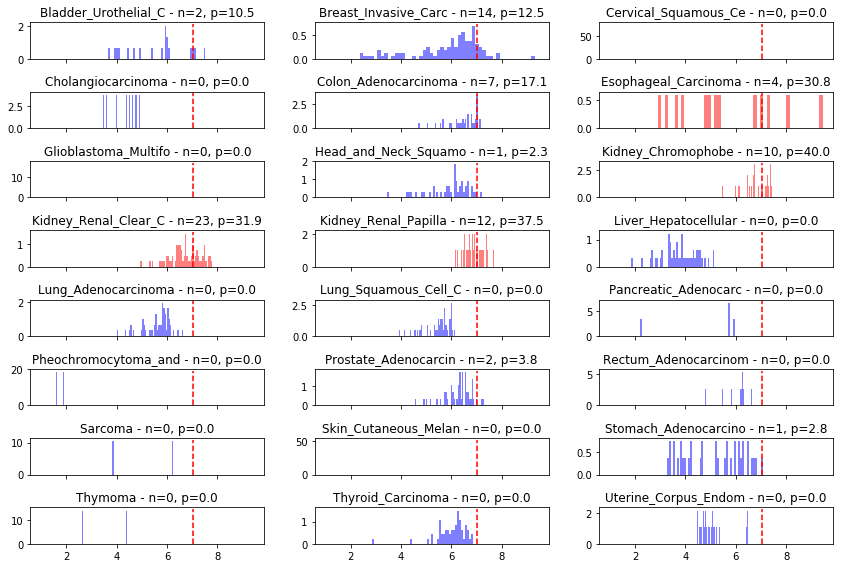

In [29]:
compare_cutoff(normal, gene, kidney_cutoff, 8, 3, figsize=(12, 8))

Meets expectations - essentially no normal samples meet the criteria for our cutoff with the exception of 3 samples from Stomach, 4 from Esophageal carcinoma, and 1 for RCC (probably contaminated). <cite data-cite="5029384/DBY4MAR2"></cite> found that CA9 is expressed in non-cancerous membranous stomach tissues. 

#### GTEx 

,Subtype,N,n,perc
17,Nerve,278,32,11.5
3,Bladder,9,1,11.1


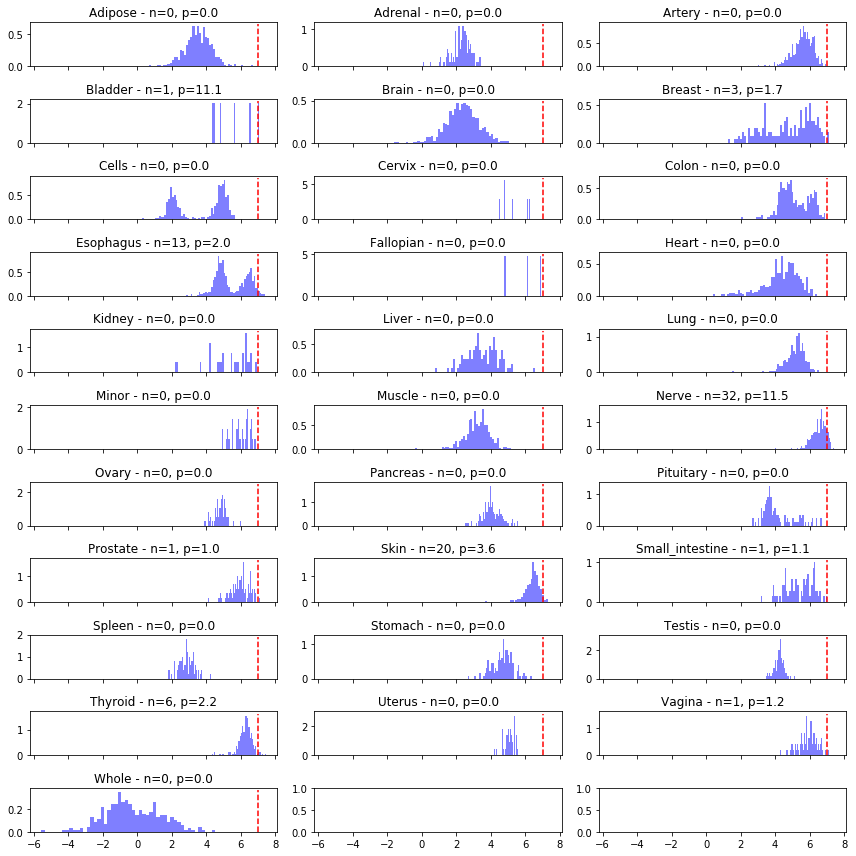

In [30]:
compare_cutoff(gtex, gene, kidney_cutoff, 11, 3, groupby='tissue', figsize=(12, 12))

The GTEx data, of which there is substantially more than than the tcga-normal set, has the same motif across normal tissues and identified the same Stomach overexpression seen in a few TCGA-normal samples and reported by <cite data-cite="5029384/DBY4MAR2"></cite>.

### Fold Change Fit

In [14]:
kidney = df[df.tissue == 'Kidney']
k_tumor = kidney[kidney.tumor == 'yes'][gene]
k_normal_med = kidney[kidney.tumor == 'no'][gene].median()
kidney_l2fc = r.diff_exp.log2fc(k_tumor, k_normal_med)

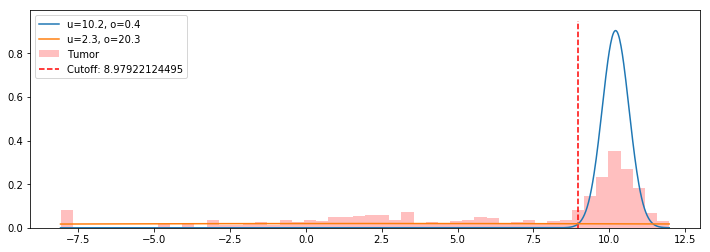

In [15]:
kidney_l2fc_cutoff = r.math.overlay_gmm_to_hist(kidney_l2fc)

Using fold change, all tumor samples would need a L2FC greater than {{kidney_l2fc_cutoff}} to be marked in the actionable subtype group, which will likely exclude most samples. Let's check with Pancreatic Adenocarcinoma samples.

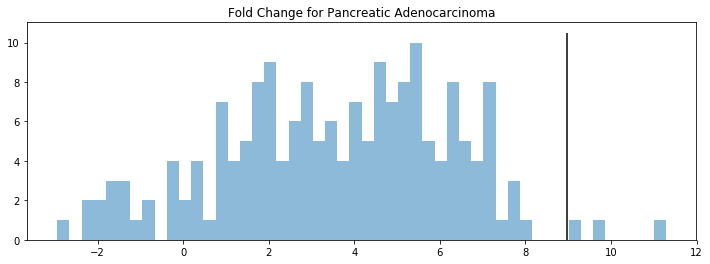

In [16]:
pan = df[df.type == 'Pancreatic_Adenocarcinoma']
p_tumor = pan[pan.tumor == 'yes'][gene]
p_normal_med = pan[pan.tumor == 'no'][gene].median()
p_l2fc = r.diff_exp.log2fc(p_tumor, p_normal_med)
plt.figure(figsize=(12, 4))
plt.hist(p_l2fc, bins=50, alpha=0.50)
plt.vlines(kidney_l2fc_cutoff, *plt.ylim(), label='Kidney L2fC Cutoff')
plt.title('Fold Change for Pancreatic Adenocarcinoma');

Using the fold change in this case excludes most of the samples in other subtypes due to how large the differential expression profile is. Another issue with using fold change is it ignores raw expression values and would have to be cross-referenced against expression values.

## CD52

CD52 is a nonmodulating antigen present on the surface of B and T lymphocytes, monocytes, macrophages, NK cells, and some granulocytes. Binding to CD52+ cells induces antibody-dependent lysis. 

- Drug: Alemtuzumab
    - Alemtuzumab is a drug used in the treatment of chronic lymphocytic leukemia (CLL), cutaneous T-cell lymphoma (CTCL) and T-cell lymphoma . It is a monoclonal antibody that binds to CD52, a protein present on the surface of mature lymphocytes, but not on the stem cells from which these lymphocytes are derived. After treatment with alemtuzumab, these CD52-bearing lymphocytes are targeted for destruction.
- Biomarker: CD52 Overexpression
- Cancer Type: B-cell lyphocytic leukemia



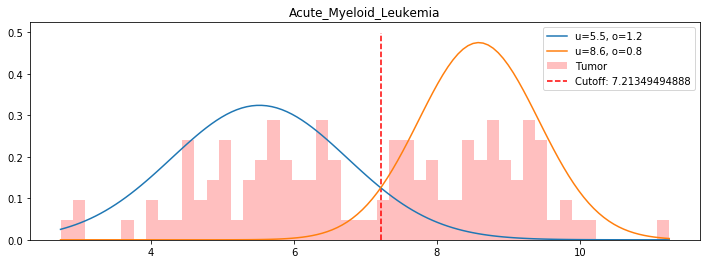

In [17]:
disease = 'Acute_Myeloid_Leukemia'
gene = 'CD52'
cd52_cutoff = gmm_fit_plot(df, label=disease, gene=gene)
plt.title(disease);

### Tumor

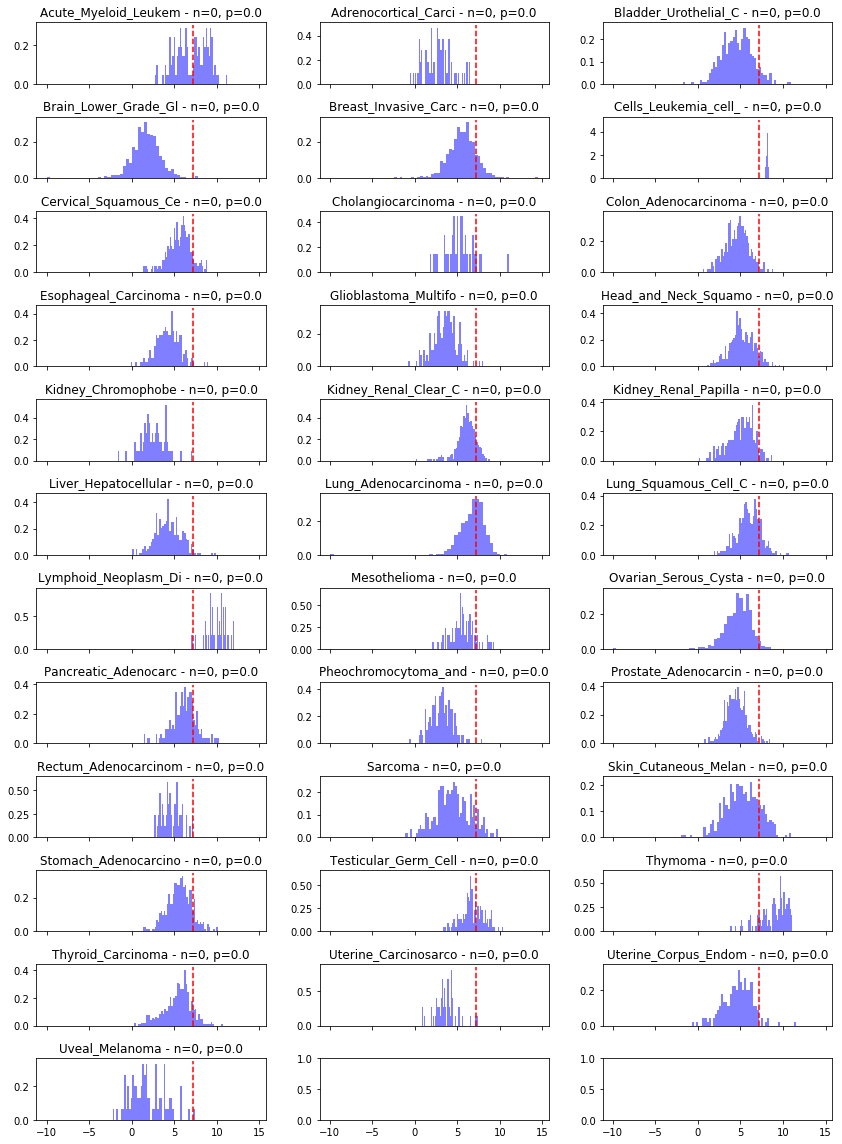

In [18]:
cd52_t = compare_cutoff(tumor, gene=gene, cutoff=cd52_cutoff, rows=12, cols=3)

In [19]:
cd52_t.head(10)

,Subtype,N,n,perc


**Possibly Interesting**: Drug is for T-tell Lymphoma but almost 100% of B-cell lymphoma's also possess the biomarker.

- Thymoma
    - "CD52, CD22, CD26, EG5 and IGF-1R expression in thymic malignancies" <cite data-cite="5029384/EXG7P3DX"></cite>
- Lung Adenocarcinoma
    - **No Articles**
- Testicular Germ Cell Tumors
    - **No Articles**
- Pancreatic Adenocarcinoma
    - **No Articles** 

### Normal

,Subtype,N,n,perc


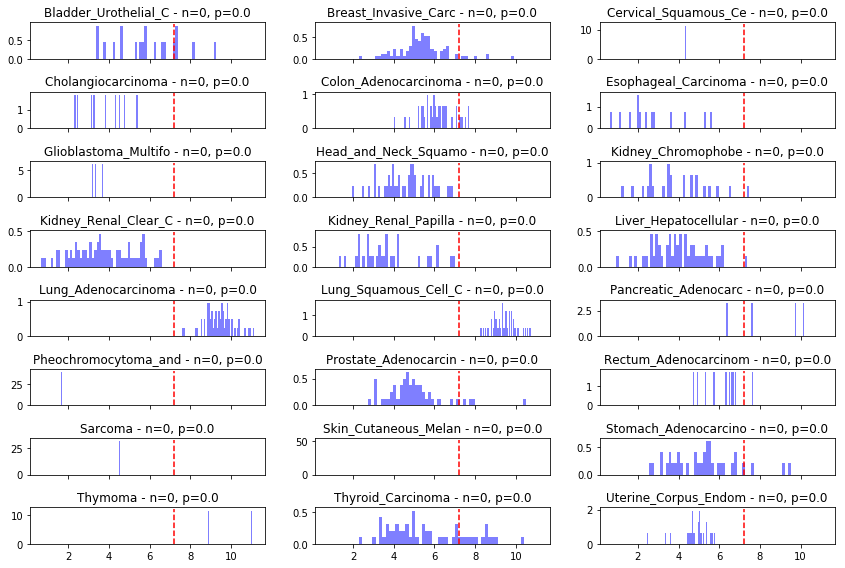

In [20]:
compare_cutoff(normal, gene, cd52_cutoff, 8, 3, figsize=(12, 8))

### GTEx

,Subtype,N,n,perc


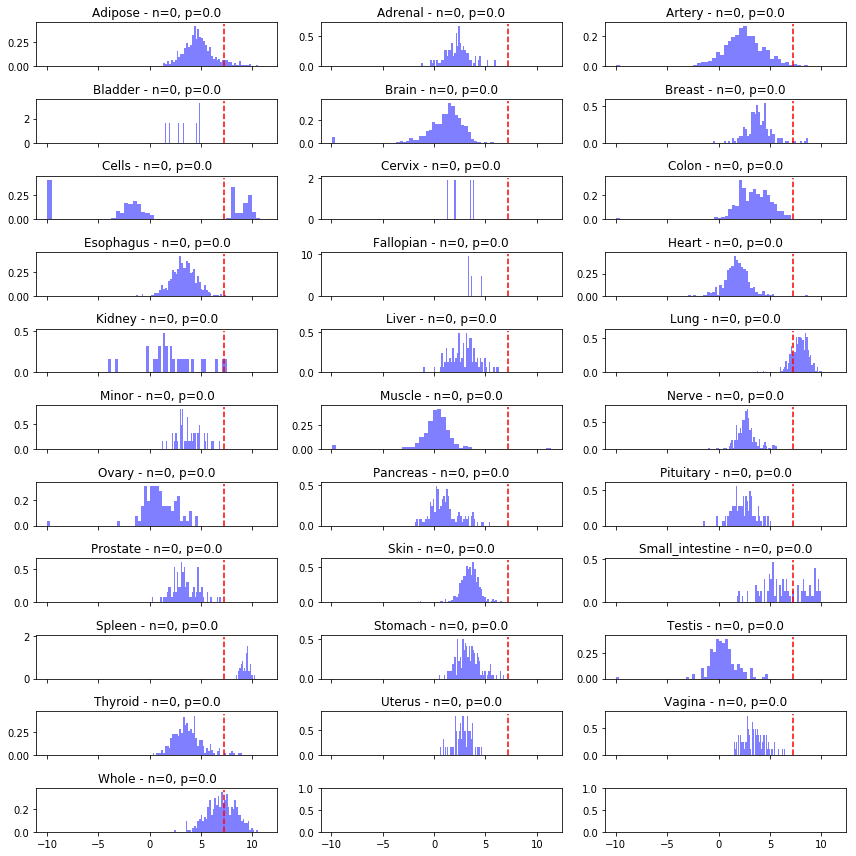

In [21]:
compare_cutoff(gtex, gene, cd52_cutoff, 11, 3, groupby='tissue', figsize=(12, 12))

### Discussion

## CD274 (PDL1)
PD-L1 may be expressed on tumor cells and tumor-infiltrating immune cells and can contribute to the inhibition of the anti-tumor immune response in the tumor microenvironment. 


- Drugs
    - Atezolizumab
    - Durvalumab
    - Avelumab
    - Nivolumab
    
- Cancer Type
    - Lung
    - Ovary
    - Breast
    - Bladder

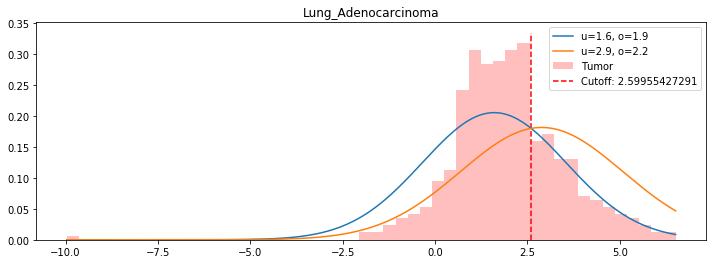

In [22]:
disease = 'Lung_Adenocarcinoma'
gene = 'CD274'
cd274_cutoff = gmm_fit_plot(df, label=disease, gene=gene)
plt.title(disease);

### Tumor 

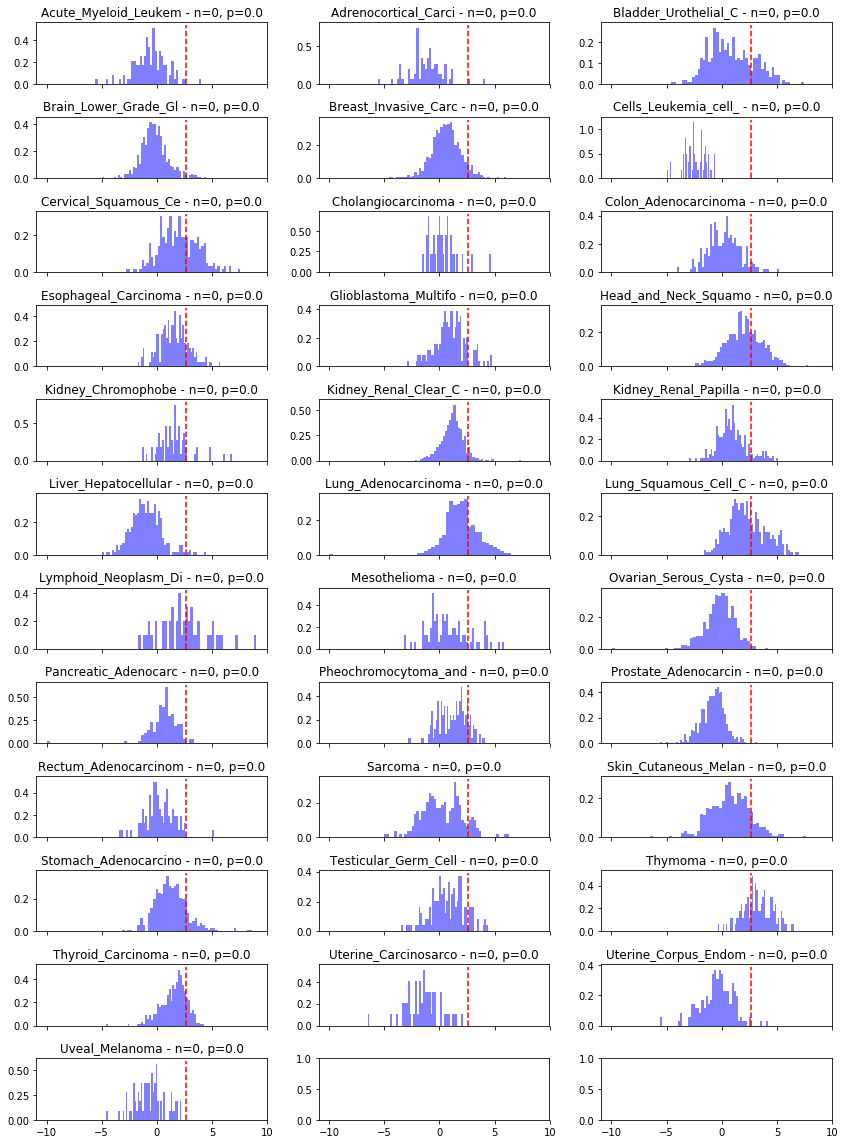

In [23]:
cd274_t = compare_cutoff(tumor, gene=gene, cutoff=cd274_cutoff, rows=12, cols=3)

In [24]:
cd274_t.head(7)

,Subtype,N,n,perc


- Thymoma
    - "PD-L1 stained positive for 70% of thymic carcinomas and 23% of thymomas." <cite data-cite="5029384/6YFWXX6A"></cite>
- Lymphoma
    - "Programmed death ligands 1 and 2 are rearranged at a frequency of 20% in PMBCL."
- Cervical Squamous Cell Carcinoma
    - We observed cogain or coamplification of CD274 and PDCD1LG2 in 32 of 48 cervical SCCs (67%) and 10 of 23 vulvar SCCs (43%). <cite data-cite="5029384/HP3R8HT9"></cite>
- Bladder Urothelial Carcinoma
    - MPDL3280A has noteworthy activity in metastatic UBC. Responses were often rapid, with many occurring at the time of the first response assessment (6 weeks) and nearly all were ongoing at the data cutoff. <cite data-cite="5029384/9JXT98GG"></cite>

### Normal

,Subtype,N,n,perc


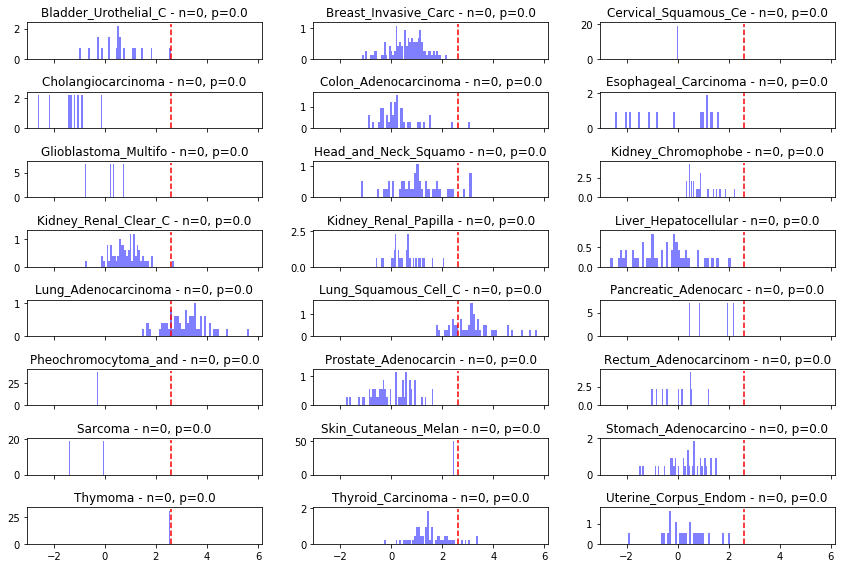

In [25]:
compare_cutoff(normal, gene, cd274_cutoff, 8, 3, figsize=(12, 8))

### GTEx

,Subtype,N,n,perc


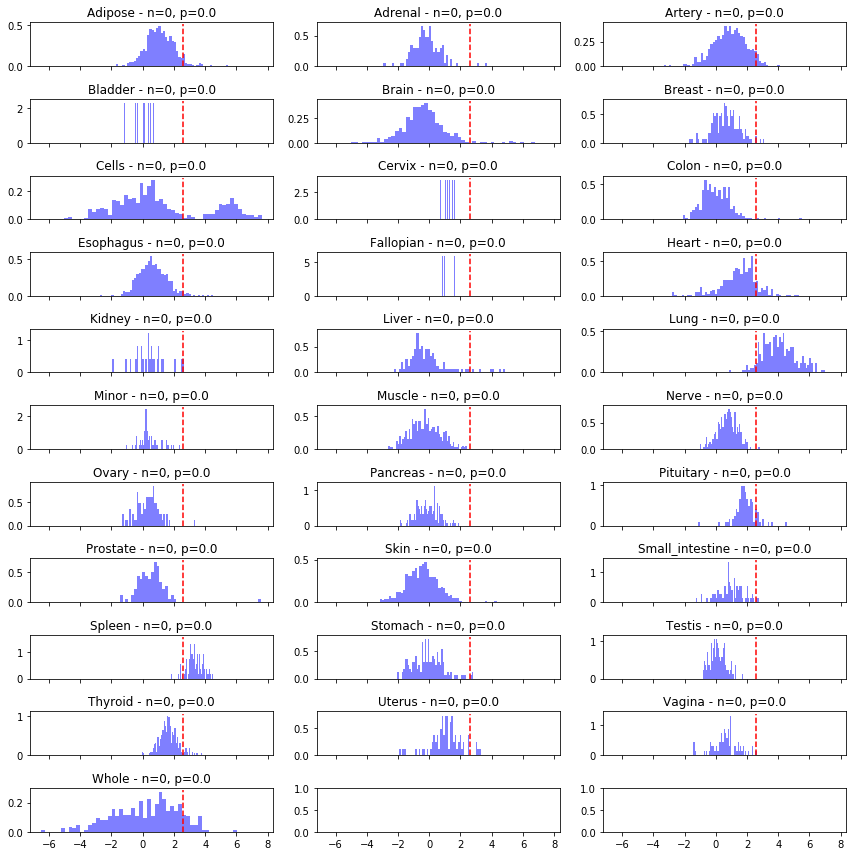

In [26]:
compare_cutoff(gtex, gene, cd274_cutoff, 11, 3, groupby='tissue', figsize=(12, 12))

### Discussion
Anti-PD1/PDL1 drugs typically target lung cancers despite the high expression of CD274 in normal tissues. Identifying patients who are appropriate to receive the drug may be difficult to do purely from expression data as the mutational rate of the tumor plays a role in the efficacy of anti-PDL1/PD1 drugs <cite data-cite="5029384/WRF9AGHU"></cite> <cite data-cite="5029384/JQGI64PB"></cite>.

## CD19

- Drugs
    - Blinatumomab
- Cancer
    - Leukemia

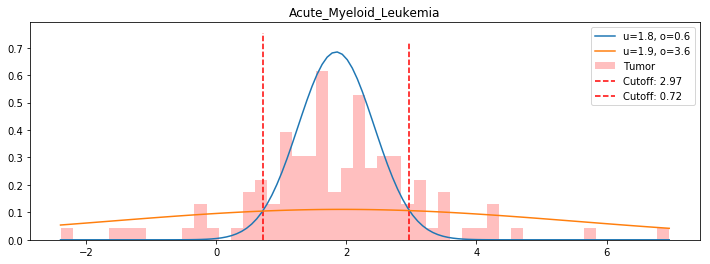

In [28]:
disease = 'Acute_Myeloid_Leukemia'
gene = 'CD19'
cd19_cutoff = gmm_fit_plot(df, label=disease, gene=gene)
plt.title(disease);

## CD33

- Drugs
    - GEMTUZUMAB OZOGAMICIN
        - Gemtuzumab is a monoclonal antibody to CD33 linked to a cytotoxic agent from the class of calicheamicins. CD33 is expressed in most leukemic blast cells but also in normal hematopoietic cells, the intensity diminishing with maturation of stem cells.
- Cancer
    - CD33+ acute myeloid leukemia

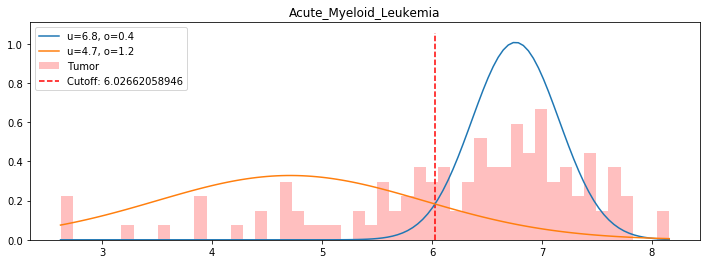

In [11]:
disease = 'Acute_Myeloid_Leukemia'
gene = 'CD33'
cd33_cutoff = gmm_fit_plot(df, label=disease, gene=gene)
plt.title(disease);

### Tumor

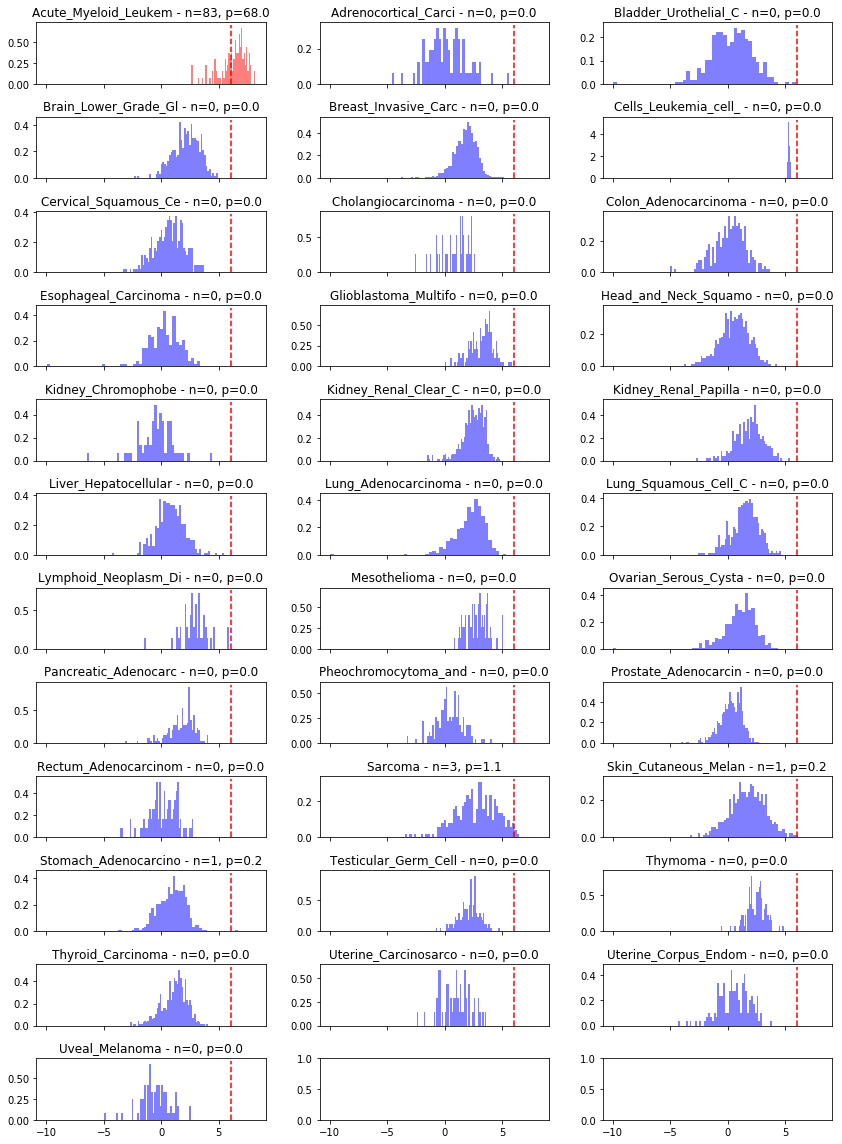

In [12]:
cd33_t = compare_cutoff(tumor, gene=gene, cutoff=cd33_cutoff, rows=12, cols=3)

### Normal

,Subtype,N,n,perc


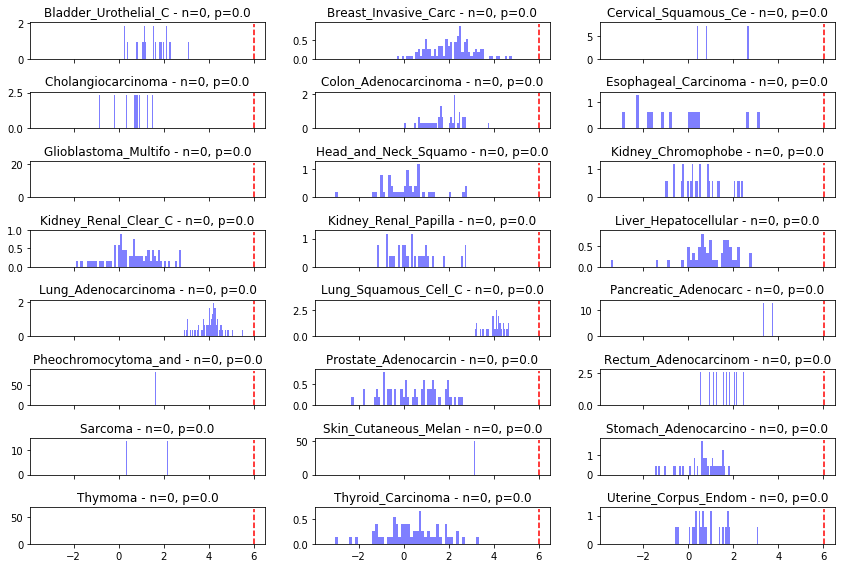

In [14]:
compare_cutoff(normal, gene, cd33_cutoff, 8, 3, figsize=(12, 8))

### GTEx

,Subtype,N,n,perc
24,Spleen,99,32,32.3


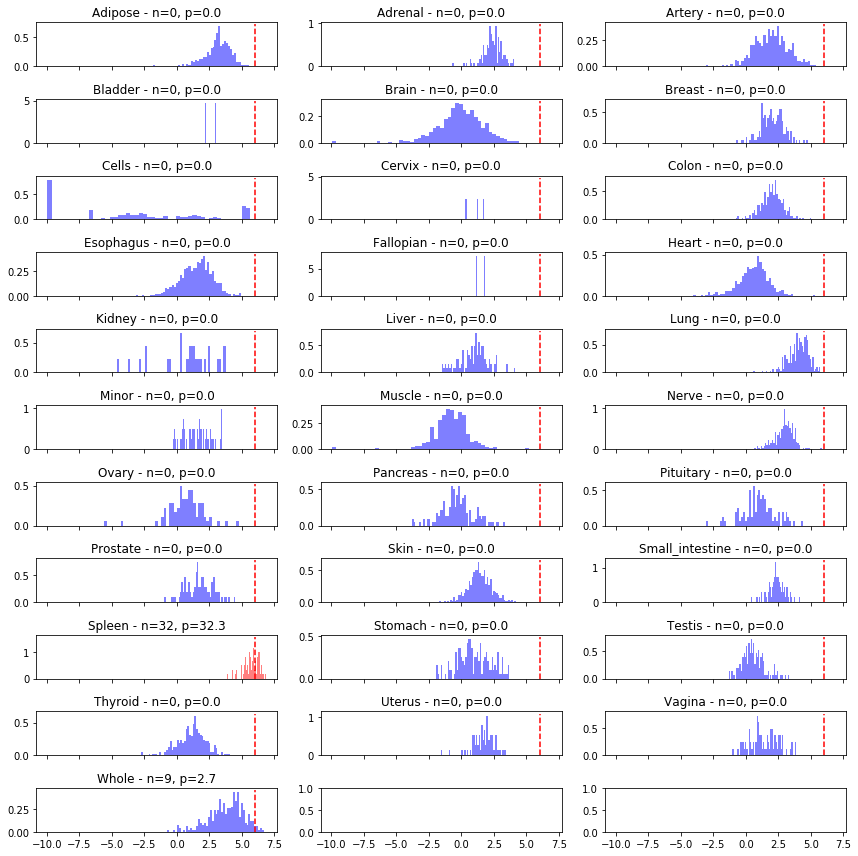

In [19]:
compare_cutoff(gtex, gene, cd33_cutoff, 11, 3, groupby='tissue', figsize=(12, 12))

## CD20

CD20

- Drugs
    - OBINUTUZUMAB
        - Obinutuzumab binds to CD20 on B cells and causes these cells to be destroyed by engaging the adaptive immune system and directly activating intracellular apoptosispathways, including complement-dependent cytotoxicity, antibody-dependent cellular cytotoxicity and antibody-dependent cellular phagocytosis.
    - OFATUMUMAB
        - Ofatumumab is a monoclonal antibody which binds specifically the extracellular (large and small) loops of the CD20 molecule (which is expressed on normal B lymphocytes and in B-cell CLL) resulting in potent complement-dependent cell cytotoxicity and antibody-dependent cell-mediated toxicity in cells that overexpress CD20.
    - RITUXIMAB
        - Rituximab is a monoclonal antibody directed against the CD20 antigen on the surface of B-lymphocytes. CD20 regulates cell cycle initiation; and, possibly, functions as a calcium channel. Rituximab binds to the antigen on the cell surface, activating complement-dependent B-cell cytotoxicity; and to human Fc receptors, mediating cell killing through an antibody-dependent cellular toxicity.
- Cancer
    - Chronic lymphocytic leukemia (CLL)

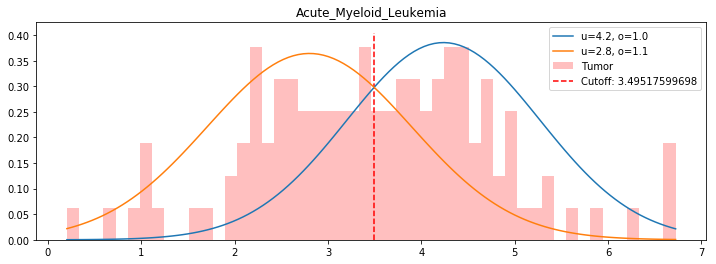

In [21]:
disease = 'Acute_Myeloid_Leukemia'
gene = 'MS4A1'
cd20_cutoff = gmm_fit_plot(df, label=disease, gene=gene)
plt.title(disease);

### Tumor

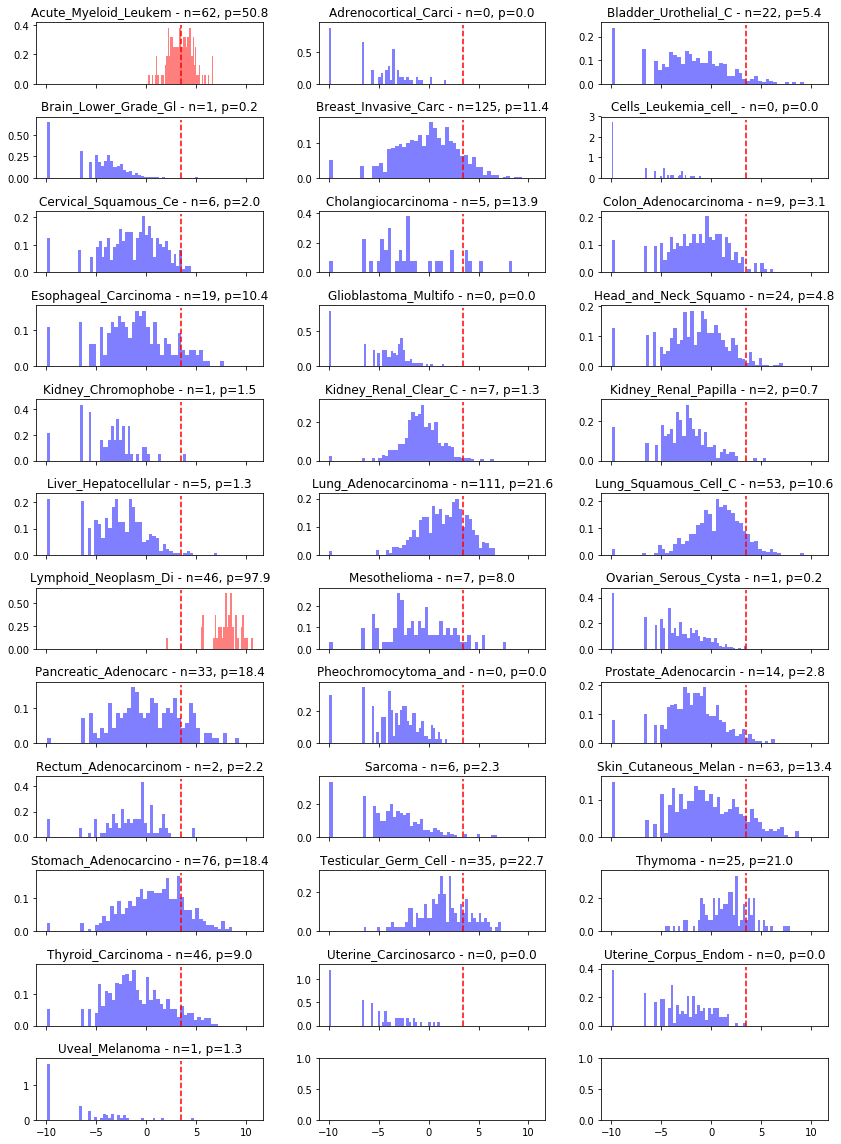

In [22]:
cd33_t = compare_cutoff(tumor, gene=gene, cutoff=cd20_cutoff, rows=12, cols=3)

In [23]:
cd33_t.head()

,Subtype,N,n,perc
18,Lymphoid_Neoplasm_Diffuse_Large_B-cell_Lymphoma,47,46,97.9
0,Acute_Myeloid_Leukemia,122,62,50.8
28,Testicular_Germ_Cell_Tumors,154,35,22.7
16,Lung_Adenocarcinoma,515,111,21.6
29,Thymoma,119,25,21.0


### Normal

,Subtype,N,n,perc
19,Skin_Cutaneous_Melanoma,1,1,100.0
21,Thymoma,2,2,100.0
17,Rectum_Adenocarcinoma,10,4,40.0
0,Bladder_Urothelial_Carcinoma,19,6,31.6
22,Thyroid_Carcinoma,59,18,30.5
14,Pancreatic_Adenocarcinoma,4,1,25.0
20,Stomach_Adenocarcinoma,36,7,19.4
4,Colon_Adenocarcinoma,41,7,17.1
5,Esophageal_Carcinoma,13,2,15.4
13,Lung_Squamous_Cell_Carcinoma,50,5,10.0


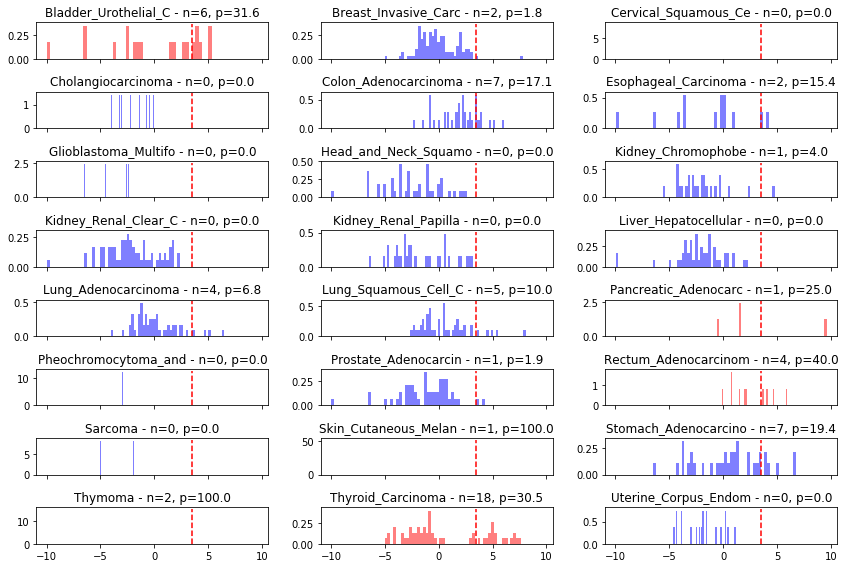

In [24]:
compare_cutoff(normal, gene, cd20_cutoff, 8, 3, figsize=(12, 8))

### GTEx

,Subtype,N,n,perc
24,Spleen,99,99,100.0
23,Small_intestine,92,54,58.7
30,Whole,337,109,32.3
6,Cells,433,107,24.7
14,Lung,287,45,15.7
12,Kidney,27,4,14.8
3,Bladder,9,1,11.1
8,Colon,304,30,9.9
21,Prostate,100,9,9.0
27,Thyroid,278,23,8.3


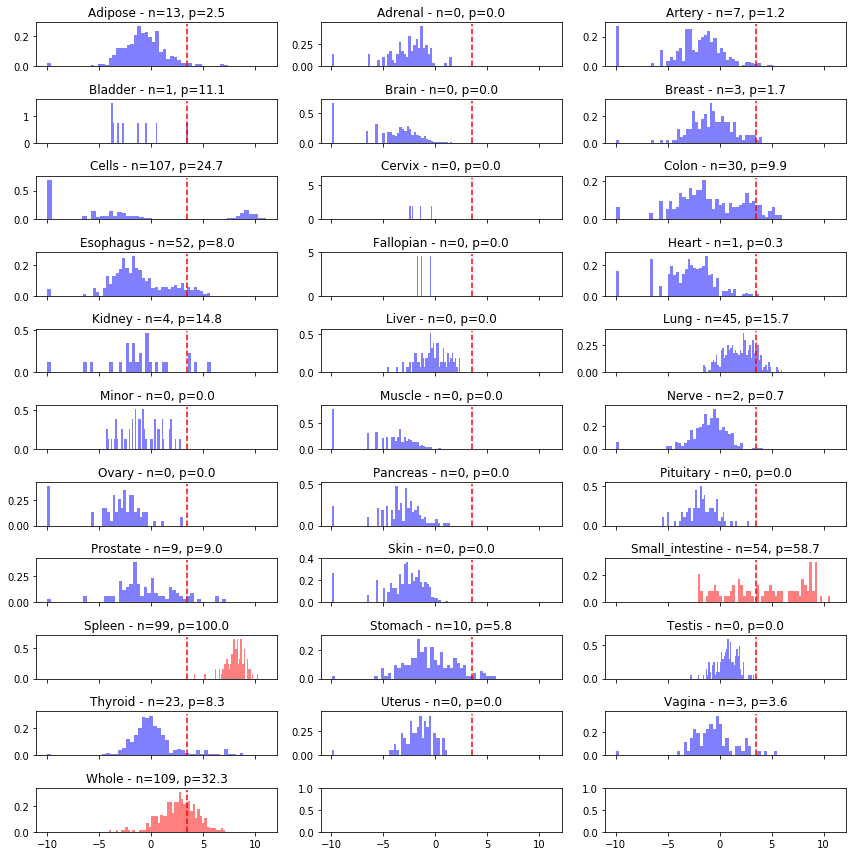

In [25]:
compare_cutoff(gtex, gene, cd20_cutoff, 11, 3, groupby='tissue', figsize=(12, 12))

## ERBB2

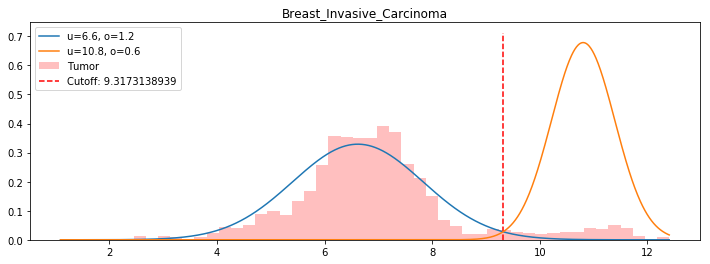

In [28]:
disease = 'Breast_Invasive_Carcinoma'
gene = 'ERBB2'
cd20_cutoff = gmm_fit_plot(df, label=disease, gene=gene)
plt.title(disease);

## ERBB2 + ESR1

# References

<div class="cite2c-biblio"></div>